In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Transition rate matrix for the network
Lambda = np.array([
    [  0, 2/5, 1/5,   0,   0],
    [  0,   0, 3/4, 1/4,   0],
    [1/2,   0,   0, 1/3,   0],
    [  0,   0, 1/3,   0, 2/3],
    [  0, 1/2,   0, 1/3,   0]
])


### ___ Helper Functions ___

In [3]:
def simulate_random_walk(origin, destination=None, Lambda=None, n_simulations=10000,seed=42):
    """
    Simulates a random walk on a graph described by the transition rate matrix.

    Parameters:
        origin (int): Starting node index.
        destination (int, optional): Target node index. If None, computes return times to origin.
        Lambda (np.ndarray): Transition rate matrix.
        n_simulations (int): Number of simulations to perform.

    Returns:
        float: Average hitting time (or return time) based on the type of computation.
        list: List of visited nodes and cumulative times for each simulation.
    """
    if Lambda is None:
        raise ValueError("Lambda (transition rate matrix) must be provided.")
    
    if seed is not None:
        np.random.seed(seed=seed)
        
    # Compute transition probabilities and exit rates
    w_star = Lambda.sum(axis=1)  # Exit rates for each node
    P = np.zeros_like(Lambda)
    for i in range(Lambda.shape[0]):
        if w_star[i] > 0:
            P[i] = Lambda[i] / w_star[i]  # Normalize non-zero rows to get probabilities


    # Array to store hitting or return times
    times = np.zeros(n_simulations, dtype=float)
    all_visited_nodes = []  # To store visited nodes for each simulation
    
    for sim in range(n_simulations):
        pos = origin  # Current position of the particle
        total_time = 0  # Total time for the walk
        visited_nodes = [(origin, 0)]  # Reset for each simulation

        while True:
            # Generate transition time for the current node
            if w_star[pos] > 0:
                t_next = -np.log(np.random.rand()) / w_star[pos]
            else:
                t_next = float('inf')  # No outgoing transitions, particle is stuck
            total_time += t_next

            # Choose the next node based on the transition probabilities
            if w_star[pos] > 0:
                next_node = np.random.choice(len(P[pos]), p=P[pos])
                visited_nodes.append((next_node, total_time))
            else:
                break  # No transitions possible

            # Check for stopping conditions
            if destination is not None and next_node == destination:
                # Hitting time: Stop when destination is reached
                break
            if destination is None and next_node == origin:
                # Return time: Stop when returning to the origin
                break

            # Update position
            pos = next_node

        # Record the total hitting/return time for this simulation
        times[sim] = total_time
        all_visited_nodes.append(visited_nodes)  # Store visited nodes for this simulation
        visited_nodes = []  # Reset for the next simulation

    # Calculate and return the average hitting/return time
    avg_time = np.mean(times)
    return avg_time, all_visited_nodes


---
---
---

### 2.EXERCISE-a

* If $N = 100$ particles all start in node $a$, what is the average time for a particle to return to node $a$?
* How does this compare to the answer in Problem 1, why?

In [5]:
start_node = 1  # Node 'a'
num_nodes = Lambda.shape[0]
Q = Lambda.copy()
np.fill_diagonal(Q, -np.sum(Q, axis=1))

A = Q.T
A[-1] = np.ones(num_nodes)
b = np.zeros(num_nodes)
b[-1] = 1


stationary_distribution = np.linalg.solve(A, b)
theoretical_return_time_a = 1 / stationary_distribution[start_node]


In [6]:
# Simulate for multiple particles
n_particles = 100
simulation = []
for _ in range(n_particles):
    simulation.append(simulate_random_walk(origin=1, destination=1, Lambda=Lambda, n_simulations=1000, seed=None))


simulationAvgTimes = np.array([entry[0] for entry in simulation])

# Compute the overall average return time
overall_simulationAvgTime = np.mean(np.array(simulationAvgTimes))

print("Overall Simulated Average Return Time:", overall_simulationAvgTime)
print("Error simulation", abs(overall_simulationAvgTime - theoretical_return_time_a))

Overall Simulated Average Return Time: 6.036858175746123
Error simulation 0.021965353665640563


### 2.Exercise-b

* If $N = 100$ particles start in node $a$, and the system is simulated for 60 time units, what is the average number of particles in the different nodes at the end of the simulation?

* Illustrate the simulation above with a plot showing the number of particles in each node during the simulation time.

* Compare the simulation result in the first point above with the stationary distribution of the continuous-time random walk followed by the single particles.

In [7]:
# Compute exit rates (omega) and transition probability matrix (P)
omega = Lambda.sum(axis=1)  # Exit rates for each node
P = Lambda / omega[:, None]  # Normalize rows to get a stochastic matrix

# Initialize particles
num_nodes = Lambda.shape[0]
num_particles = 100
initial_node = 1  # Node 'a' (index 1)
n_particles = np.zeros(num_nodes)
n_particles[initial_node] = num_particles

# Simulation parameters
simulation_time = 60
current_time = 0

# Initialize time to the next departure for each node
np.random.seed(42)  # For reproducibility
time_next_departure = np.full(num_nodes, np.inf)
for node in range(num_nodes):
    if n_particles[node] > 0:
        time_next_departure[node] = np.random.exponential(1 / (n_particles[node] * omega[node]))


# Track particles over time
particle_counts = [n_particles.copy()]
time_points = [0]

while current_time < simulation_time:
    # Find the next event (minimum departure time)
    next_event_node = np.argmin(time_next_departure)
    next_event_time = time_next_departure[next_event_node]

    # Advance time to the next event
    current_time = next_event_time
    if current_time > simulation_time:
        break

    # Handle the departure
    n_particles[next_event_node] -= 1
    destination = np.random.choice(num_nodes, p=P[next_event_node])
    n_particles[destination] += 1

    # Update time for the node that had the event
    if n_particles[next_event_node] > 0:
        time_next_departure[next_event_node] = current_time + np.random.exponential( 1 / (n_particles[next_event_node] * omega[next_event_node]))
    else:
        time_next_departure[next_event_node] = np.inf  # No events for empty nodes

    # Update time for the destination node
    time_next_departure[destination] = current_time + np.random.exponential( 1 / (n_particles[destination] * omega[destination]))

    # Record particle counts and time
    particle_counts.append(n_particles.copy())
    time_points.append(current_time)

particle_counts = np.array(particle_counts)


# Compute the average number of particles in each node at the end of the simulation
average_particles = particle_counts.mean(axis=0)

# Theoretical stationary distribution
stationary_distribution = omega / omega.sum()

# Scale stationary distribution to match the total number of particles
scaled_stationary = stationary_distribution * num_particles

# Print results
print("Average number of particles per node (simulation):", average_particles)
print("Stationary distribution (scaled):", scaled_stationary)

Average number of particles per node (simulation): [23.56698991 17.23213932 28.59152978 16.91826638 13.69107461]
Stationary distribution (scaled): [14.0625  23.4375  19.53125 23.4375  19.53125]


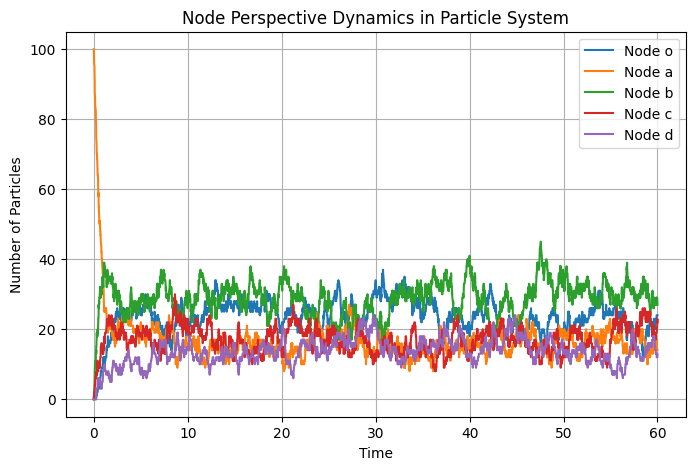

In [8]:
# Plot results
plt.figure(figsize=(8, 5))
time_points = np.array(time_points)
nodes = ['o', 'a', 'b', 'c', 'd']
for node in range(num_nodes):
    plt.plot(time_points, particle_counts[:, node], label=f"Node {nodes[node]}",)

plt.xlabel("Time")
plt.ylabel("Number of Particles")
plt.title("Node Perspective Dynamics in Particle System")
plt.legend()
plt.grid()
plt.savefig("node_perspective.jpg")
plt.show()
